In [1]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.metrics import structure_score
from pgmpy.utils import get_example_model
from pgmpy.estimators import ScoreCache
from pgmpy.inference.CausalInference import CausalInference
import networkx as nx
import bnlearn as bn
import itertools
import math

# Brute Force exact SDP

In [2]:
def exact_sdp_bruteforce(model, D, d_value, evidence, threshold):
    """
    Exact brute-force computation of Same-Decision Probability (SDP).
    
    Parameters:
        model      : pgmpy Bayesian model
        D          : decision variable name (string)
        d_value    : state of D to test (e.g., 1 or 'yes')
        evidence   : dict of observed variables {var: value}
        threshold  : decision threshold T
        
    Returns:
        sdp (float)
    """
    # 1. Identify hidden variables (H)
    all_vars = set(model.nodes())
    observed_vars = set(evidence.keys())
    H = list(all_vars - observed_vars - {D})
    
    inference = VariableElimination(model)

    # 2. Determine the CURRENT decision (F(Pr(D|e)))
    # We must know if we are currently above or below the threshold
    current_dist = inference.query(variables=[D], evidence=evidence, show_progress=False)
    d_index = model.get_cpds(D).state_names[D].index(d_value)
    p_d_initial = current_dist.values[d_index]
    
    # The decision function F returns 1 if >= threshold, else 0
    current_decision = p_d_initial >= threshold

    # 3. Setup hidden variable state space
    state_spaces = [model.get_cpds(var).state_names[var] for var in H]
    all_assignments = list(itertools.product(*state_spaces))

    # 4. Pre-compute P(H | e) to get the weights for each scenario
    p_h_dist = inference.query(variables=H, evidence=evidence, show_progress=False)

    sdp = 0.0

    # 5. Iterate through all possible hidden variable instantiations (h)
    for assignment in all_assignments:
        h_dict = dict(zip(H, assignment))

        # Get the probability of this specific scenario: Pr(h | e)
        p_h_given_e = p_h_dist.get_value(**h_dict)

        if p_h_given_e == 0:
            continue

        # 6. Compute the NEW probability: Pr(d | e, h)
        query_e_h = {**evidence, **h_dict}
        p_d_given_e_h_dist = inference.query(
            variables=[D],
            evidence=query_e_h,
            show_progress=False
        )
        p_d_given_e_h = p_d_given_e_h_dist.values[d_index]

        # 7. Check if the decision is the SAME: [F(Pr(D|e,h)) == F(Pr(D|e))]
        new_decision = p_d_given_e_h >= threshold
        
        if new_decision == current_decision:
            sdp += p_h_given_e

    return sdp

In [3]:
data = pd.read_csv("../data/asia10K.csv")
data = data.replace({'yes': 1, 'no': 0})
data.rename(columns={
    'Smoker': 'S',
    'LungCancer': 'L',
    'VisitToAsia': 'A',
    'Tuberculosis': 'T',
    'TuberculosisOrCancer': 'E',
    'X-ray': 'X',
    'Bronchitis': 'B',
    'Dyspnea': 'D'
}, inplace=True)

In [4]:
asia_graph = BayesianModel([('A', 'T'), ('S', 'L'), ('S', 'B'), ('L', 'E'), ('T', 'E'), ('E', 'X'), ('E', 'D'), ('B', 'D')])
asia_graph.fit(data, estimator=MaximumLikelihoodEstimator)

In [5]:
asia_graph.nodes()

NodeView(('A', 'T', 'S', 'L', 'B', 'E', 'X', 'D'))

In [6]:
sdp = exact_sdp_bruteforce(asia_graph, D='B', d_value=1, evidence={'D': 1, 'A': 1}, threshold=0.5)

In [7]:
sdp

0.9317318433235299

In [8]:
# Figure 3 from 2014 paper to test SDP calculation

from pgmpy.factors.discrete import TabularCPD


model = BayesianNetwork([('D','S1'), ('D','S2')])

# Prior
cpd_D = TabularCPD(
    variable='D',
    variable_card=2,
    values=[[0.5],[0.5]],
    state_names={'D':['+','-']}
)

# S1
cpd_S1 = TabularCPD(
    variable='S1',
    variable_card=2,
    values=[
        [0.2, 0.8],   # S1=-
        [0.8, 0.2]    # S1=+
    ],
    evidence=['D'],
    evidence_card=[2],
    state_names={'S1':['-','+'], 'D':['+','-']}
)

# S2 (3 states)
cpd_S2 = TabularCPD(
    variable='S2',
    variable_card=3,
    values=[
        [0.05, 0.75],  # -
        [0.20, 0.20],  # o
        [0.75, 0.05]   # +
    ],
    evidence=['D'],
    evidence_card=[2],
    state_names={'S2':['-','o','+'], 'D':['+','-']}
)

model.add_cpds(cpd_D, cpd_S1, cpd_S2)
model.check_model()


True

In [9]:
# compute P(S2='+' | D=+) and P(S2='+' | D=-
inference = VariableElimination(model)
p_s2_plus_given_d_plus = inference.query(variables=['S2'], evidence={'D': '+'}, show_progress=False).values[2]
p_s2_plus_given_d_minus = inference.query(variables=['S2'], evidence={'D': '-'}, show_progress=False).values[2]
print("P(S2='+' | D=+):", p_s2_plus_given_d_plus)
print("P(S2='+' | D=-):", p_s2_plus_given_d_minus)

P(S2='+' | D=+): 0.75
P(S2='+' | D=-): 0.05


In [10]:
# compute P(S1=+ | D=+) and P(S1=+ | D=-)
inference = VariableElimination(model)
p_s1_plus_given_d_plus = inference.query(variables=['S1'], evidence={'D': '+'}, show_progress=False).values[1]
p_s1_plus_given_d_minus = inference.query(variables=['S1'], evidence={'D': '-'}, show_progress=False).values[1]
print("P(S1='+' | D=+):", p_s1_plus_given_d_plus)
print("P(S1='+' | D=-):", p_s1_plus_given_d_minus)

P(S1='+' | D=+): 0.8
P(S1='+' | D=-): 0.2


In [11]:
# compute P(S2='o'| D=+) and P(S2='o'| D=-)
p_s2_o_given_d_plus = inference.query(variables=['S2'], evidence={'D': '+'}, show_progress=False).values[1]
p_s2_o_given_d_minus = inference.query(variables=['S2'], evidence={'D': '-'}, show_progress=False).values[1]
print("P(S2='o' | D=+):", p_s2_o_given_d_plus)
print("P(S2='o' | D=-):", p_s2_o_given_d_minus)

P(S2='o' | D=+): 0.2
P(S2='o' | D=-): 0.2


In [12]:
sdp_initial = exact_sdp_bruteforce(
    model,
    D='D',
    d_value='+',
    evidence={'S2':'+'},
    threshold=0.8
)

print("Initial SDP:", sdp_initial)

Initial SDP: 0.7625


# Boostrap SDP estimates

In [13]:
def bootstrapped_sdp_estimation(model, D, d_value, evidence, threshold, n_samples=100, n_bootstraps=50):
    """
    Estimates SDP variance by sampling hidden variable configurations.
    """
    # 1. Identify hidden variables (H)
    all_vars = set(model.nodes())
    observed_vars = set(evidence.keys())
    H = list(all_vars - observed_vars - {D})
    
    inference = VariableElimination(model)
    d_index = model.get_cpds(D).state_names[D].index(d_value)

    # 2. Determine the CURRENT decision F(Pr(D|e))
    current_dist = inference.query(variables=[D], evidence=evidence, show_progress=False)
    current_decision = current_dist.values[d_index] >= threshold

    # 3. Get the conditional distribution P(H | e)
    # This is the "population" we sample from
    p_h_dist = inference.query(variables=H, evidence=evidence, show_progress=False)
    
    # Flatten the distribution into a list of assignments and their probabilities
    # pgmpy's DiscreteFactor.values is a multi-dimensional array
    h_states = [model.get_cpds(var).state_names[var] for var in H]
    
    # Create a dataframe of all possible H configurations and their probabilities
    import itertools
    all_configs = list(itertools.product(*h_states))
    probabilities = p_h_dist.values.flatten()
    
    # Filter out zero-probability states to speed up sampling
    valid_indices = np.where(probabilities > 0)[0]
    filtered_configs = [all_configs[i] for i in valid_indices]
    filtered_probs = probabilities[valid_indices]
    filtered_probs /= filtered_probs.sum() # Normalize to ensure it sums to 1

    sdp_estimates = []

    for b in range(n_bootstraps):
        # 4. Uniformly sample a subset of hidden configurations
        # Note: We sample from the 'possibilities' then weigh by their actual P(h|e)
        # OR we sample according to P(h|e) and just count matches. 
        # Sampling according to P(h|e) is usually more efficient for variance study.
        indices = np.random.choice(len(filtered_configs), size=n_samples, p=filtered_probs)
        
        matches = 0
        for idx in indices:
            h_dict = dict(zip(H, filtered_configs[idx]))
            
            # 5. Compute Pr(d | e, h)
            query_e_h = {**evidence, **h_dict}
            p_d_given_e_h_dist = inference.query([D], evidence=query_e_h, show_progress=False)
            new_decision = p_d_given_e_h_dist.values[d_index] >= threshold
            
            if new_decision == current_decision:
                matches += 1
        
        # 6. SDP Estimate for this bootstrap run
        sdp_estimates.append(matches / n_samples)

    return np.array(sdp_estimates)

In [14]:
sdp_estimates = bootstrapped_sdp_estimation(asia_graph, D='B', d_value=1, evidence={'D': 1, 'A': 1}, threshold=0.5, n_samples=100, n_bootstraps=50)

In [15]:
sdp_estimates

array([0.96, 0.91, 0.95, 0.93, 0.94, 0.96, 0.9 , 0.93, 0.95, 0.95, 0.97,
       0.89, 0.93, 0.95, 0.93, 0.91, 0.94, 0.91, 0.95, 0.97, 0.95, 0.95,
       0.95, 0.95, 0.93, 0.93, 0.94, 0.94, 0.96, 0.95, 0.95, 0.9 , 0.97,
       0.92, 0.92, 0.96, 0.95, 0.92, 0.92, 0.92, 0.9 , 0.9 , 0.93, 0.96,
       0.97, 0.94, 0.93, 0.94, 0.87, 0.94])

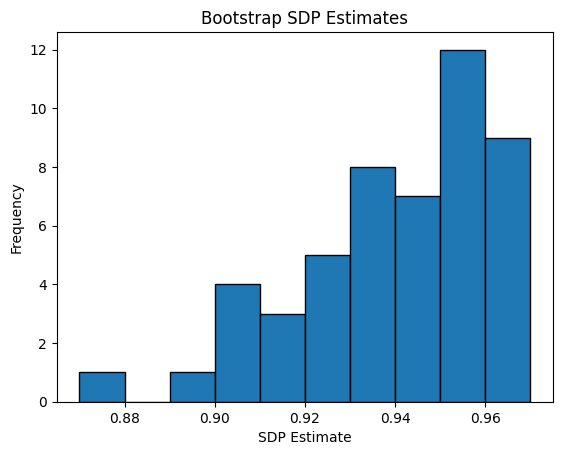

In [16]:
#plot estimates histogram
import matplotlib.pyplot as plt
plt.hist(sdp_estimates, bins=10, edgecolor='black')
plt.title('Bootstrap SDP Estimates')
plt.xlabel('SDP Estimate')
plt.ylabel('Frequency')
plt.show()

# Tree Search exact SDP

In [17]:
def get_partitions(model, H, D, E):
    """
    Finds independent partitions of H given D and E by pruning the network structure.
    Based on Section 5.2.1 of Chen, Choi, & Darwiche (2014).
    """
    # Create a directed graph from the model
    G = nx.DiGraph(model.edges())
    
    # 1. Delete edges outgoing from nodes in evidence E and hypothesis D
    nodes_to_cut = set(E.keys()) | {D}
    for node in nodes_to_cut:
        if node in G:
            edges_to_remove = list(G.out_edges(node))
            G.remove_edges_from(edges_to_remove)
            
    # 2. Successively delete all leaf nodes that are neither in H, E, or D
    keep_nodes = set(H) | set(E.keys()) | {D}
    while True:
        # A node is a leaf if out_degree is 0
        leaves = [n for n, d in G.out_degree() if d == 0 and n not in keep_nodes]
        if not leaves:
            break
        G.remove_nodes_from(leaves)
        
    # 3. Identify weakly connected components to form partitions S_i
    components = list(nx.weakly_connected_components(G))
    
    # Extract only the variables in H for each component
    partitions = []
    for comp in components:
        s_i = list(set(comp) & set(H))
        if s_i:  # Only keep non-empty partitions
            partitions.append(s_i)
            
    return partitions

In [18]:
def exact_sdp_tree_search(model, D, d_value, evidence, threshold):
    """
    Exact computation of SDP for arbitrary networks using partitions.
    Implements the generalized approach from Section 5.2.
    """
    inference = VariableElimination(model)
    
    all_vars = set(model.nodes())
    observed_vars = set(evidence.keys())
    H = list(all_vars - observed_vars - {D})
    
    # Get opposite state for D
    d_states = model.get_cpds(D).state_names[D]
    d_index = d_states.index(d_value)
    not_d_value = d_states[1] if d_index == 0 else d_states[0]

    # 1. Compute Initial Log-Odds and Lambda
    initial_dist = inference.query(variables=[D], evidence=evidence, show_progress=False)
    p_d_e = initial_dist.get_value(**{D: d_value})
    p_not_d_e = initial_dist.get_value(**{D: not_d_value})
    
    log_O_d_e = math.log(p_d_e / p_not_d_e) if p_not_d_e > 0 else float('inf')
    lambda_threshold = math.log(threshold / (1 - threshold))
    current_decision_positive = (log_O_d_e >= lambda_threshold)

    # 2. Get Partitions S_1, ..., S_k
    partitions = get_partitions(model, H, D, evidence)
    
    # 3. Compute Weights of Evidence for all Aggregate Attributes S_i
    weights = []
    for s_i in partitions:
        s_i_weights = {}
        # Get all state combinations for the variables in this partition
        state_spaces = [model.get_cpds(var).state_names[var] for var in s_i]
        all_s_i_assignments = list(itertools.product(*state_spaces))
        
        # Query joint distribution of S_i given D and e
        dist_given_d = inference.query(variables=s_i, evidence={**evidence, D: d_value}, show_progress=False)
        dist_given_not_d = inference.query(variables=s_i, evidence={**evidence, D: not_d_value}, show_progress=False)
        
        for assignment in all_s_i_assignments:
            assign_dict = dict(zip(s_i, assignment))
            
            p_s_d = dist_given_d.get_value(**assign_dict)
            p_s_not_d = dist_given_not_d.get_value(**assign_dict)
            
            p_s_d = max(p_s_d, 1e-9)
            p_s_not_d = max(p_s_not_d, 1e-9)
            
            # Using tuple as dictionary key to represent the joint state
            s_i_weights[tuple(assignment)] = math.log(p_s_d / p_s_not_d)
            
        weights.append({
            'vars': s_i,
            'weights': s_i_weights,
            'max': max(s_i_weights.values()),
            'min': min(s_i_weights.values())
        })

    # Order partitions by max upper/lower bound difference for better pruning
    weights.sort(key=lambda w: w['max'] - w['min'], reverse=True)

    # 4. DFS Function with Aggregate Attributes
    def dfs_sdp(q_dict, depth):
        # Calculate current log odds
        w_q = 0
        for i in range(depth):
            s_vars = weights[i]['vars']
            s_assignment = tuple(q_dict[v] for v in s_vars)
            w_q += weights[i]['weights'][s_assignment]
            
        current_log_odds = log_O_d_e + w_q
        
        # Calculate Bounds using remaining partitions
        remaining_max = sum(w['max'] for w in weights[depth:])
        remaining_min = sum(w['min'] for w in weights[depth:])
        
        upper_bound = current_log_odds + remaining_max
        lower_bound = current_log_odds + remaining_min
        
        def get_prob_q():
            if not q_dict: return 1.0
            dist = inference.query(variables=list(q_dict.keys()), evidence=evidence, show_progress=False)
            return dist.get_value(**q_dict)

        # --- PRUNING LOGIC ---
        if current_decision_positive:
            if lower_bound >= lambda_threshold: return get_prob_q()
            if upper_bound < lambda_threshold: return 0.0
        else:
            if upper_bound < lambda_threshold: return get_prob_q()
            if lower_bound >= lambda_threshold: return 0.0
        
        if depth == len(weights):
            is_positive = current_log_odds >= lambda_threshold
            if is_positive == current_decision_positive:
                return get_prob_q()
            return 0.0
            
        # Recursive Step over the Aggregate Attribute (Partition)
        s_vars = weights[depth]['vars']
        state_spaces = [model.get_cpds(var).state_names[var] for var in s_vars]
        all_s_i_assignments = list(itertools.product(*state_spaces))
        
        total_sdp = 0.0
        for assignment in all_s_i_assignments:
            new_q = q_dict.copy()
            for var, state in zip(s_vars, assignment):
                new_q[var] = state
            total_sdp += dfs_sdp(new_q, depth + 1)
            
        return total_sdp

    return dfs_sdp({}, 0)

In [19]:
def optimized_tree_search_sdp(model, D, d_value, evidence, threshold, partitions):
    """
    Highly optimized exact SDP computation. 
    Removes pgmpy inference from the DFS loop by leveraging conditional independence.
    """
    inference = VariableElimination(model)
    
    # Get opposite state for D
    d_states = model.get_cpds(D).state_names[D]
    d_index = d_states.index(d_value)
    not_d_value = d_states[1] if d_index == 0 else d_states[0]

    # 1. Compute Initial Log-Odds and Lambda
    initial_dist = inference.query(variables=[D], evidence=evidence, show_progress=False)
    p_d_e = initial_dist.get_value(**{D: d_value})
    p_not_d_e = initial_dist.get_value(**{D: not_d_value})
    print(f"Initial P(D|e): {p_d_e}, P(not D|e): {p_not_d_e}")
    
    log_O_d_e = math.log(p_d_e / p_not_d_e) if p_not_d_e > 0 else float('inf')
    lambda_threshold = math.log(threshold / (1 - threshold))
    current_decision_positive = (log_O_d_e >= lambda_threshold)
    print(f"Initial Log-Odds: {log_O_d_e}, Lambda: {lambda_threshold}, Current Decision Positive: {current_decision_positive}")

    # 2. Precompute all probabilities and weights outside the search tree
    partitions_data = []
    
    for s_i in partitions:
        state_spaces = [model.get_cpds(var).state_names[var] for var in s_i]
        all_s_i_assignments = list(itertools.product(*state_spaces))
        
        # Query joint distribution of S_i given D and e
        dist_given_d = inference.query(variables=s_i, evidence={**evidence, D: d_value}, show_progress=False)
        dist_given_not_d = inference.query(variables=s_i, evidence={**evidence, D: not_d_value}, show_progress=False)
        
        states_info = []
        max_w = -float('inf')
        min_w = float('inf')
        
        for assignment in all_s_i_assignments:
            assign_dict = dict(zip(s_i, assignment))
            
            p_s_d = max(dist_given_d.get_value(**assign_dict), 1e-12)
            p_s_not_d = max(dist_given_not_d.get_value(**assign_dict), 1e-12)
            
            w = math.log(p_s_d / p_s_not_d)
            max_w = max(max_w, w)
            min_w = min(min_w, w)
            
            states_info.append({
                'w': w,
                'p_d': p_s_d,
                'p_not_d': p_s_not_d
            })
            
        partitions_data.append({
            'states': states_info,
            'max_w': max_w,
            'min_w': min_w
        })

    # Sort partitions by max variance for optimal early pruning
    partitions_data.sort(key=lambda x: x['max_w'] - x['min_w'], reverse=True)

    # 3. Precompute Suffix Sums for O(1) bound lookups
    n_parts = len(partitions_data)
    suffix_max = [0] * (n_parts + 1)
    suffix_min = [0] * (n_parts + 1)
    
    for i in range(n_parts - 1, -1, -1):
        suffix_max[i] = suffix_max[i+1] + partitions_data[i]['max_w']
        suffix_min[i] = suffix_min[i+1] + partitions_data[i]['min_w']

    # 4. Lightning-Fast DFS
    def dfs(depth, current_log_odds, prob_cond_d, prob_cond_not_d):
        # O(1) Bound calculations
        upper_bound = current_log_odds + suffix_max[depth]
        lower_bound = current_log_odds + suffix_min[depth]
        
        # O(1) Probability calculation leveraging conditional independence
        def get_prob_q():
            return (p_d_e * prob_cond_d) + (p_not_d_e * prob_cond_not_d)

        # --- PRUNING LOGIC ---
        if current_decision_positive:
            if lower_bound >= lambda_threshold: return get_prob_q()
            if upper_bound < lambda_threshold: return 0.0
        else:
            if upper_bound < lambda_threshold: return get_prob_q()
            if lower_bound >= lambda_threshold: return 0.0
        
        # Leaf node evaluation
        if depth == n_parts:
            is_positive = current_log_odds >= lambda_threshold
            if is_positive == current_decision_positive:
                return get_prob_q()
            return 0.0
            
        # Recursive Step passing state as arguments (no dict copies needed)
        total_sdp = 0.0
        for state_data in partitions_data[depth]['states']:
            total_sdp += dfs(
                depth + 1,
                current_log_odds + state_data['w'],
                prob_cond_d * state_data['p_d'],
                prob_cond_not_d * state_data['p_not_d']
            )
            
        return total_sdp

    # Start DFS with base probabilities of 1.0 (multiplicative identity)
    return dfs(0, log_O_d_e, 1.0, 1.0)

In [20]:
sdp = exact_sdp_tree_search(
    model,
    D='D',
    d_value='+',
    evidence={'S2':'+'},
    threshold=0.8
)
print(sdp)

0.7625


In [21]:
sdp = optimized_tree_search_sdp(
    model,
    D='D',
    d_value='+',
    evidence={'S2':'+'},
    threshold=0.8,
    partitions=get_partitions(model, ['S1'], 'D', {'S2': '+'})
)
print(sdp)

Initial P(D|e): 0.9375, P(not D|e): 0.0625
Initial Log-Odds: 2.70805020110221, Lambda: 1.3862943611198908, Current Decision Positive: True
0.7625


In [22]:
sdp = exact_sdp_tree_search(asia_graph, D='B', d_value=1, evidence={'D': 1, 'A': 1}, threshold=0.5)
print("SDP for Asia graph:", sdp)

SDP for Asia graph: 0.9317318433235299


In [23]:
def test_figure_7_partitions():
    # 1. Define the network structure based on Figure 7
    edges = [
        ('E1', 'X1'), ('E1', 'D'),
        ('D', 'X1'), ('D', 'H1'), ('D', 'H3'), ('D', 'E2'), ('D', 'X3'),
        ('H4', 'D'),
        ('X1', 'H1'),
        ('H1', 'X2'), ('H1', 'H2'),
        ('X2', 'H2'), ('X2', 'H3'),
        ('H3', 'E2'),
        ('E2', 'X3'), ('E2', 'H6'),
        ('H5', 'X3'),
        ('X3', 'H6')
    ]
    
    model = BayesianNetwork(edges)
    
    # 2. Define our sets based on the paper
    # D is the decision variable, E are the observed evidence, H are the hidden variables
    decision_var = 'D'
    evidence = {'E1': 1, 'E2': 1} # The actual values don't matter for the structure pruning
    hidden_vars = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']
    
    # 3. Run the partitioning algorithm
    print("Running partitioning on Figure 7 network...")
    partitions = get_partitions(model, hidden_vars, decision_var, evidence)
    
    # 4. Display the results
    for i, part in enumerate(partitions, 1):
        # Sorting just for cleaner display output
        print(f"S{i} = {sorted(part)}")

In [24]:
test_figure_7_partitions() # tested and works!

Running partitioning on Figure 7 network...
S1 = ['H1', 'H2', 'H3']
S2 = ['H4']
S3 = ['H5', 'H6']


# Lower Bound computation

In [25]:
def estimate_sdp_lower_bound(model, inference, D, d_value, evidence, threshold):
    """
    Estimates the Same-Decision Probability (SDP) bound using exact variance 
    and the one-sided Chebyshev inequality.
    """
    # Identify hidden variables (H)
    all_vars = set(model.nodes())
    observed_vars = set(evidence.keys())
    H = list(all_vars - observed_vars - {D})

    # 1. Compute E[Q(H)] = Pr(d | e) directly
    dist_D = inference.query(variables=[D], evidence=evidence, show_progress=False)
    d_index = model.get_cpds(D).state_names[D].index(d_value)
    EQ = dist_D.values[d_index] 

    # 2. Compute Pr(H | e) to look up state probabilities
    dist_H_given_e = inference.query(variables=H, evidence=evidence, show_progress=False)

    state_spaces = [model.get_cpds(var).state_names[var] for var in H]
    all_assignments = list(itertools.product(*state_spaces))

    EQ2 = 0.0

    # 3. Iterate over all combinations of h to find E[Q(H)^2]
    for assignment in all_assignments:
        h_dict = dict(zip(H, assignment))
        
        # Look up Pr(h | e) from our pre-computed distribution
        # Note: In pgmpy, extracting specific joint states can be done via reduce
        p_h_given_e = dist_H_given_e.copy()
        p_h_given_e.reduce(list(h_dict.items()))
        p_h_given_e_val = p_h_given_e.values.item()

        if p_h_given_e_val == 0:
            continue

        query_e_h = evidence.copy()
        query_e_h.update(h_dict)

        # Compute Q(h) = Pr(d | e, h)
        q_dist = inference.query(variables=[D], evidence=query_e_h, show_progress=False)
        q_val = q_dist.values[d_index]

        EQ2 += (q_val ** 2) * p_h_given_e_val

    # 4. Compute Variance
    variance = EQ2 - (EQ ** 2)

    # 5. Apply the one-sided Chebyshev inequality
    # Bound formula: Var / (Var + (E[Q] - T)^2)
    if EQ >= threshold:
        # Decision confirmed: we want P(Q(H) >= T)
        sdp_bound = 1 - (variance / (variance + (EQ - threshold)**2))
    else:
        # Decision rejected: we want P(Q(H) <= T)
        sdp_bound = 1 - (variance / (variance + (threshold - EQ)**2))

    return sdp_bound, variance, EQ

In [26]:
lb, var, mean = estimate_sdp_lower_bound(asia_graph, VariableElimination(asia_graph), D='B', d_value=1, evidence={'D': 1, 'A': 1}, threshold=0.5)
print(f"Estimated SDP Bound: {lb}, Variance: {var}, Mean: {mean}")

Estimated SDP Bound: 0.7948101207153082, Variance: 0.023984248065152758, Mean: 0.8048012754399733


# Testing Child network

In [27]:
child = pd.read_csv("/home/joao/Desktop/UFMG/PhD/code/explaining-BN/data/child.csv")

In [28]:
# load ground truth DAG
child_graph = nx.read_gml("/home/joao/Desktop/UFMG/PhD/code/explaining-BN/data/child.gml")
# convert to pgmpy format
edges = list(child_graph.edges())
child_model = BayesianNetwork(edges)
child_model.fit(child, estimator=MaximumLikelihoodEstimator)

In [29]:
patient1 = {'Disease': 1, 'ChestXray': 1, 'CO2Report': 0, 'XrayReport': 1}
target = 'Sick'
# P(Disease=1 | evidence) for patient 1
inference_child = VariableElimination(child_model)
p_disease_given_evidence = inference_child.query(variables=[target], evidence=patient1, show_progress=False).values[1]
print(f"P(Disease=1 | evidence) for patient 1: {p_disease_given_evidence}")

P(Disease=1 | evidence) for patient 1: 0.7032479869718629


In [30]:
#H_child = set(model_child.nodes()) - set(patient1.keys()) - {target}
H_child = ['DuctFlow', 'CO2', 'Age', 'BirthAsphyxia', 
           'LVHReport', 'LowerBodyO2', 'LungFlow', 'Grunting', 'LungParench', 'CardiacMixing', 'LVH']
sdp_patient1 = optimized_tree_search_sdp(
    child_model,
    D=target,
    d_value=1,
    evidence=patient1,
    threshold=0.5, # USANDO 0.5 O SDP NAO MUDA EM FUNCAO DO D VALUE
    partitions=get_partitions(child_model, H_child, target, patient1)
)
print(f"SDP for patient 1: {sdp_patient1}")

Initial P(D|e): 0.7032479869718629, P(not D|e): 0.29675201302813714
Initial Log-Odds: 0.8628127678520303, Lambda: 0.0, Current Decision Positive: True
SDP for patient 1: 0.9440456390425063


In [31]:
partitions = get_partitions(child_model, set(child_model.nodes()) - set(patient1.keys()) - {target}, target, patient1)
for i, part in enumerate(partitions, 1):
    print(f"S{i} = {sorted(part)}")

S1 = ['CO2', 'CardiacMixing', 'DuctFlow', 'Grunting', 'GruntingReport', 'HypDistrib', 'HypoxiaInO2', 'LowerBodyO2', 'LungFlow', 'LungParench', 'RUQO2']
S2 = ['Age']
S3 = ['LVH', 'LVHreport']
S4 = ['BirthAsphyxia']


In [32]:
def classify_partitions(model, evidence, D, d_value, H, threshold):
    
    partitions = get_partitions(model, H, D, evidence)
    inference = VariableElimination(model)
    
    # Get opposite state for D
    d_states = model.get_cpds(D).state_names[D]
    d_index = d_states.index(d_value)
    not_d_value = d_states[1] if d_index == 0 else d_states[0]
    
    # 1. Compute Initial Log-Odds identically to the SDP function
    dist_D = inference.query(variables=[D], evidence=evidence, show_progress=False)
    p_d_e = dist_D.get_value(**{D: d_value})
    p_not_d_e = dist_D.get_value(**{D: not_d_value})
    
    log_O_d_e = math.log(p_d_e / p_not_d_e) if p_not_d_e > 0 else float('inf')
    lambda_threshold = math.log(threshold / (1 - threshold))
    is_positive_decision = (log_O_d_e >= lambda_threshold)
    
    evidence_d = evidence.copy()
    evidence_d[D] = d_value
    
    evidence_not_d = evidence.copy()
    evidence_not_d[D] = not_d_value
    
    classifications = {}
    
    # 2. Evaluate each partition's bounds
    for partition in partitions:
        # Query the joint distribution
        dist_S_given_d = inference.query(variables=partition, evidence=evidence_d, show_progress=False).values
        dist_S_given_not_d = inference.query(variables=partition, evidence=evidence_not_d, show_progress=False).values
        
        # Identical weight calculation: Use the 1e-12 hard floor instead of additive epsilon
        # Vectorized via numpy to strictly match the math of max(val, 1e-12) while preserving speed
        p_s_d = np.maximum(dist_S_given_d, 1e-12)
        p_s_not_d = np.maximum(dist_S_given_not_d, 1e-12)
        
        log_weights = np.log(p_s_d / p_s_not_d)
        
        # Extract the worst-case and best-case log-odds impact
        w_min = np.min(log_weights)
        w_max = np.max(log_weights)
        swing = w_max - w_min
        
        # 3. Classify for Natural Language Generation in medical diagnostic systems
        if is_positive_decision:
            if log_O_d_e + w_min < lambda_threshold:
                category = "Potential Reverser"
                explanation = "Some combination of these variables could change the current positive diagnosis."
            else:
                category = "Stable"
                explanation = "This group of variables cannot change the positive diagnosis."
        else:
            if log_O_d_e + w_max >= lambda_threshold:
                category = "Potential Reverser"
                explanation = "Some combination of these variables could change the diagnosis."
            else:
                category = "Stable"
                explanation = "This group of variables is not enough to change the negative diagnosis."
                
        classifications[tuple(partition)] = {
            "category": category,
            "explanation": explanation,
            "w_min": w_min,
            "w_max": w_max,
            "swing": swing
        }
        
    return classifications


investigar o efeito do maior w na direção contrária da decisão atual

In [33]:
classifications = classify_partitions(child_model, patient1, D=target, d_value=1, H=H_child, threshold=0.5)
for part, info in classifications.items():
    print(f"Partition: {part}, \nCategory: {info['category']}, Explanation: {info['explanation']}, Swing: {info['swing']:.4f}")

Partition: ('DuctFlow', 'LungParench', 'LowerBodyO2', 'CO2', 'CardiacMixing', 'Grunting', 'LungFlow'), 
Category: Potential Reverser, Explanation: Some combination of these variables could change the current positive diagnosis., Swing: 2.0808
Partition: ('Age',), 
Category: Stable, Explanation: This group of variables cannot change the positive diagnosis., Swing: 0.8056
Partition: ('LVH',), 
Category: Stable, Explanation: This group of variables cannot change the positive diagnosis., Swing: 0.0000
Partition: ('BirthAsphyxia',), 
Category: Stable, Explanation: This group of variables cannot change the positive diagnosis., Swing: 0.0000


In [34]:
# estimation for patient 1
sdp_estimates_patient1 = bootstrapped_sdp_estimation(child_model, D=target, d_value=1, evidence=patient1, threshold=0.7, n_samples=100, n_bootstraps=50)
print(f"Bootstrap SDP estimates for patient 1: {sdp_estimates_patient1}")

Bootstrap SDP estimates for patient 1: [0.66 0.82 0.75 0.72 0.78 0.71 0.74 0.69 0.73 0.79 0.8  0.79 0.76 0.75
 0.79 0.71 0.81 0.71 0.73 0.77 0.82 0.77 0.8  0.77 0.75 0.78 0.75 0.75
 0.81 0.73 0.79 0.82 0.72 0.71 0.74 0.73 0.75 0.82 0.67 0.76 0.7  0.77
 0.72 0.78 0.78 0.85 0.74 0.78 0.72 0.82]


## Interesting SDP pitfall

mostrar esse exemplo para discutir a robustez da decisão em função do valor específico de D

In [50]:
patient2 = {'ChestXray': 1, 'CO2Report': 0, 'XrayReport': 1}
target = 'Sick'
H_child = ['DuctFlow', 'CO2', 'Age', 'BirthAsphyxia', 
           'LVHReport', 'LowerBodyO2', 'LungFlow', 'Grunting', 'LungParench', 'CardiacMixing', 'LVH']
sdp_patient2 = optimized_tree_search_sdp(
    child_model,
    D=target,
    d_value=1,
    evidence=patient2,
    threshold=0.7,
    partitions=get_partitions(child_model, H_child, target, patient2)
)
print(f"SDP for patient 2, dvalue = 1: {sdp_patient2}")

sdp_patient2 = optimized_tree_search_sdp(
    child_model,
    D=target,
    d_value=0,
    evidence=patient2,
    threshold=0.3,
    partitions=get_partitions(child_model, H_child, target, patient2)
)
print(f"SDP for patient 2, dvalue = 0: {sdp_patient2}")

Initial P(D|e): 0.7318861968880331, P(not D|e): 0.26811380311196686
Initial Log-Odds: 1.0042135042876585, Lambda: 0.8472978603872034, Current Decision Positive: True
SDP for patient 2, dvalue = 1: 0.67921593093056
Initial P(D|e): 0.26811380311196686, P(not D|e): 0.7318861968880331
Initial Log-Odds: -1.0042135042876585, Lambda: -0.8472978603872036, Current Decision Positive: False
SDP for patient 2, dvalue = 0: 0.67921593093056


# Testing ASIA network

In [51]:
patient1 = {'S': 0}
target = 'B'


In [52]:
#P(D=1 | evidence) for patient 1
inference_asia = VariableElimination(asia_graph)
p_d_given_evidence_asia = inference_asia.query(variables=[target], evidence=patient1, show_progress=False).values[1]
print(f"P(target=1 | evidence) for patient 1 in ASIA graph: {p_d_given_evidence_asia}")

P(target=1 | evidence) for patient 1 in ASIA graph: 0.291393361160803


In [53]:
partitions = get_partitions(asia_graph, set(asia_graph.nodes()) - set(patient1.keys()) - {target}, target, patient1)
for i, part in enumerate(partitions, 1):
    print(f"S{i} = {sorted(part)}")

S1 = ['A', 'D', 'E', 'L', 'T', 'X']


In [54]:
sdp_patient1_asia = exact_sdp_tree_search(asia_graph, D=target, d_value=1, evidence=patient1, threshold=0.5)
print(f"SDP for patient 1 in ASIA graph: {sdp_patient1_asia}")

SDP for patient 1 in ASIA graph: 0.7067478177073655


In [60]:
# monte carlo
sdp_estimates_patient1_asia = bootstrapped_sdp_estimation(asia_graph, D=target, d_value=1, evidence=patient1, threshold=0.5, n_samples=100, n_bootstraps=50)
print(f"Bootstrap SDP estimates for patient 1 in ASIA graph: {sdp_estimates_patient1_asia}")

Bootstrap SDP estimates for patient 1 in ASIA graph: [0.76 0.77 0.7  0.69 0.73 0.7  0.76 0.68 0.81 0.68 0.68 0.68 0.67 0.75
 0.68 0.69 0.81 0.72 0.61 0.65 0.68 0.63 0.77 0.69 0.76 0.66 0.81 0.66
 0.67 0.74 0.61 0.75 0.68 0.75 0.64 0.7  0.65 0.7  0.66 0.71 0.72 0.79
 0.71 0.68 0.71 0.68 0.64 0.67 0.7  0.66]


In [55]:
def get_decision_flipping_scenarios(model, D, d_value, evidence, threshold):
    """
    Identifies the exact hidden variable scenarios that would flip the current decision.
    
    Returns a list of dictionaries containing:
      - 'scenario': The specific hidden variable instantiation.
      - 'prob_scenario': How likely this scenario is to happen, Pr(h|e).
      - 'new_decision_prob': The new probability of the diagnosis, Pr(D|h,e).
    """
    inference = VariableElimination(model)
    
    # 1. Identify hidden variables
    all_vars = set(model.nodes())
    observed_vars = set(evidence.keys())
    H = list(all_vars - observed_vars - {D})
    
    # 2. Determine the CURRENT decision
    current_dist = inference.query(variables=[D], evidence=evidence, show_progress=False)
    d_index = model.get_cpds(D).state_names[D].index(d_value)
    p_d_initial = current_dist.values[d_index]
    
    current_decision = p_d_initial >= threshold
    
    # 3. Setup state spaces for iteration
    state_spaces = [model.get_cpds(var).state_names[var] for var in H]
    all_assignments = list(itertools.product(*state_spaces))
    
    # Pre-compute Pr(h|e)
    p_h_dist = inference.query(variables=H, evidence=evidence, show_progress=False)
    
    flipped_scenarios = []
    
    # 4. Evaluate each scenario
    for assignment in all_assignments:
        h_dict = dict(zip(H, assignment))
        
        # Pr(h|e)
        p_h_given_e = p_h_dist.get_value(**h_dict)
        if p_h_given_e == 0:
            continue
            
        # Pr(D | e, h)
        query_e_h = {**evidence, **h_dict}
        p_d_given_e_h_dist = inference.query(variables=[D], evidence=query_e_h, show_progress=False)
        p_d_given_e_h = p_d_given_e_h_dist.values[d_index]
        
        # 5. Check if the decision FLIPS
        new_decision = p_d_given_e_h >= threshold
        
        if new_decision != current_decision:
            flipped_scenarios.append({
                'scenario': h_dict,
                'prob_scenario': p_h_given_e,
                'new_decision_prob': p_d_given_e_h
            })
            
    # Sort the flipped scenarios by how likely they are to occur (highest probability first)
    flipped_scenarios.sort(key=lambda x: x['prob_scenario'], reverse=True)
    
    return {
        'current_prob': p_d_initial,
        'current_decision': current_decision,
        'threshold': threshold,
        'flipping_scenarios': flipped_scenarios
    }

In [56]:
scenarios = get_decision_flipping_scenarios(asia_graph, D='B', d_value=1, evidence=patient1, threshold=0.5) 

In [57]:
scenarios['current_prob']

0.291393361160803

In [58]:
scenarios['current_decision']

False

In [59]:
scenarios['flipping_scenarios'][:5]  # top 5 most likely flipping scenarios

[{'scenario': {'T': 0, 'X': 0, 'A': 0, 'D': 1, 'E': 0, 'L': 0},
  'prob_scenario': 0.27606281971029745,
  'new_decision_prob': 0.7805916555867882},
 {'scenario': {'T': 0, 'X': 1, 'A': 0, 'D': 1, 'E': 0, 'L': 0},
  'prob_scenario': 0.014613078642171394,
  'new_decision_prob': 0.780591655586788},
 {'scenario': {'T': 0, 'X': 0, 'A': 1, 'D': 1, 'E': 0, 'L': 0},
  'prob_scenario': 0.002446767045109604,
  'new_decision_prob': 0.7805916555867882},
 {'scenario': {'T': 0, 'X': 1, 'A': 1, 'D': 1, 'E': 0, 'L': 0},
  'prob_scenario': 0.00012951689505592004,
  'new_decision_prob': 0.7805916555867881}]

In [46]:
classifications = classify_partitions(asia_graph, patient1, D=target, d_value=1, H=set(asia_graph.nodes()) - set(patient1.keys()) - {target}, threshold=0.5)

In [47]:
print("Partition classifications for ASIA graph:")
for part, info in classifications.items():
    print(f"Partition: {part}, Category: {info['category']}, Explanation: {info['explanation']}, Swing: {info['swing']:.4f}")   

Partition classifications for ASIA graph:
Partition: ('L', 'T'), Category: Stable, Explanation: This group of variables is not enough to change the negative diagnosis., Swing: 0.0000
Partition: ('B', 'D'), Category: Stable, Explanation: This group of variables is not enough to change the negative diagnosis., Swing: 0.0000
Partition: ('X',), Category: Stable, Explanation: This group of variables is not enough to change the negative diagnosis., Swing: 0.0000


# Explaining the current evidence

In [ ]:
# Rank the variables inside e by their individual impact, comparing P(D|e) vs P(D|e - {var})
def rank_evidence_variables(model, D, d_value, evidence, threshold):
    inference = VariableElimination(model)
    
    # Get opposite state for D
    d_states = model.get_cpds(D).state_names[D]
    d_index = d_states.index(d_value)
    not_d_value = d_states[1] if d_index == 0 else d_states[0]
    
    # Compute baseline probability with all evidence
    dist_full = inference.query(variables=[D], evidence=evidence, show_progress=False)
    p_d_full = dist_full.values[d_index]
    
    variable_impact = []
    
    for var in evidence.keys():
        reduced_evidence = {k: v for k, v in evidence.items() if k != var}
        dist_reduced = inference.query(variables=[D], evidence=reduced_evidence, show_progress=False)
        p_d_reduced = dist_reduced.values[d_index]
        
        impact = abs(p_d_full - p_d_reduced)
        variable_impact.append((var, impact))
        
    variable_impact.sort(key=lambda x: x[1], reverse=True)
    
    return variable_impact

